# A. Genetic Programming for Regression

This notebook shows how to use TurboGP through the sci-kit learn-alike interface for quick usage in ML tasks. Here we use the same problem setup as in notebooks 01 and 02, but without going into too much detail about the configuration of TurboGP; instead, we simply initialize a GP object with some straightforward parameters, and then call `fit` and `predict` functions, as one would do in sci-kit learn.

Import necessary libraries...

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from genetic_program import GeneticProgram

from Regressor import *          # GP individual we will use
from GPUtils import binary_tournament

Create training dataset:

In [2]:
# Training set

# samples
x_training = np.random.rand(1000,1)
x_training = (x_training * 6.28) - 3.14

# labels
y_training = np.sin(x_training).flatten()

Create some testing data:

In [3]:
# Testing set

# samples
x_testing = np.random.rand(200,1)
x_testing = (x_testing * 6.28) - 3.14

# labels
y_testing = np.sin(x_testing).flatten()

Define GP run parameters:

In [4]:
lowlevel = ['ADD', 'SUB', 'MUL', 'DIV', 'X2', 'MAX', 'MEAN', 'MIN', 'RELU'] # Primitives
GeneticProgram.set_primitives(lowlevel=lowlevel)

#gp_individual_class = SimpleRegresor            # Type of individual to evolve
ind_params = {'input_vector_size':1, 'complexity':7} 

oper = [SimpleRegresor.mutation,                 # Genetic operations to use.
        SimpleRegresor.protected_crossover]      # notice how they are defined by the type of individual we will evolve

oper_prob = [.5, .5]                             # Probabity of each GP operation (in the same order as declared above)
oper_arity = [1, 2]                              # How many parents required by each operation.

Initialize predictor using a regressor as GP individual to evolve:

In [5]:
GP = GeneticProgram(individual_class=SimpleRegresor , 
                    ind_params=ind_params, 
                    operations=oper, 
                    operations_prob=oper_prob, 
                    operations_arity=oper_arity, 
                    pop_size=1000, 
                    generations=50,
                    pop_dynamics="Steady_State", 
                    online=False, 
                    minimization=True)

Train/Evolve it!

In [6]:
gp_reg = GP.fit(x_training, y_training)

First evaluation time cost:  0:00:08.658322


100%|██████████| 50/50 [08:12<00:00,  9.85s/it, Training Fitness=0.01]  

Training fitness of best individual found:  0.010037773731209846


Test it on testing dataset:

**NOTE: GP objects implement a function called 'natural_score', that evaluates the performance of the generated model against a testing dataset using the same metric used as fitness function during the evolutionary process. The term 'natural' is used to distinguish it from the 'score' function from sci-kit learn that uses** $R^2$ coefficient

In [7]:
GP.natural_score(x_testing, y_testing)

0.0121067821943734

Plot generated GP tree:

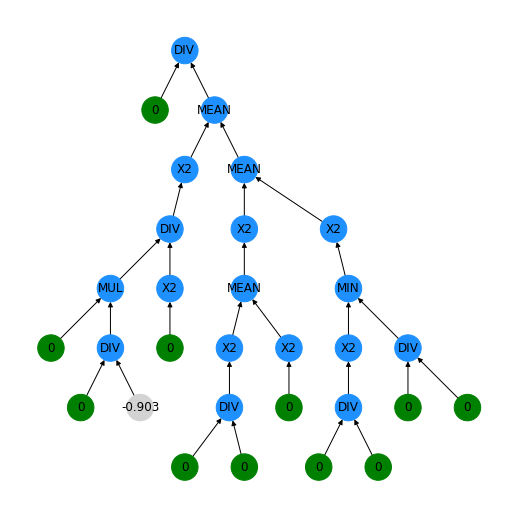

In [8]:
from GPUtils import get_graph
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout


plt.figure(figsize=(7,7))
graph, labels, color_map = get_graph(gp_reg.tree)
nx.draw(graph, pos=nx.nx_agraph.graphviz_layout(graph.reverse(), prog="dot"), with_labels=True, labels=labels, node_size=700, node_color=color_map)

Plot behavior of function approximation against groud truth:

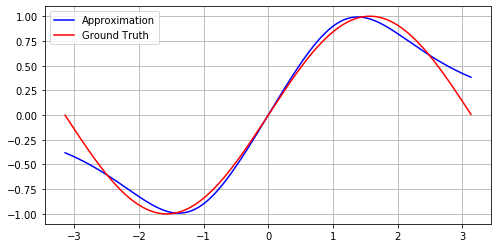

In [9]:
x = np.arange(1000)
x = ((x / 1000) * 6.28) - 3.14
x = x.reshape(1000,1)

y = GP.predict(x)
y2 = np.sin(x)

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.grid(True)

line1, = ax.plot(x, y, 'b-', label='Approximation')
line2, = ax.plot(x, y2, 'r-', label='Ground Truth')

ax.legend()
plt.show()

---

### Same example as above, but with online learning... same performance in a fraction of the time.

In [10]:
batchesX = x_training.reshape(10, 100, 1)
batchesY = y_training.reshape(10, 100)

In [16]:
GP_online = GeneticProgram(individual_class=SimpleRegresor , 
                           ind_params=ind_params, 
                           operations=oper, 
                           operations_prob=oper_prob, 
                           operations_arity=oper_arity, 
                           pop_size=1000, 
                           epochs=5,
                           pop_dynamics="Steady_State", 
                           online=True, 
                           minimization=True)

In [17]:
GP_online.fit(batchesX, batchesY)

First evaluation time cost:  0:00:00.932252


100%|██████████| 50/50 [02:53<00:00,  3.48s/it, Training Fitness=0.00512]

Training fitness of best individual found:  0.005118924718450499


In [18]:
GP_online.natural_score(x_testing, y_testing)

0.007711306059668264

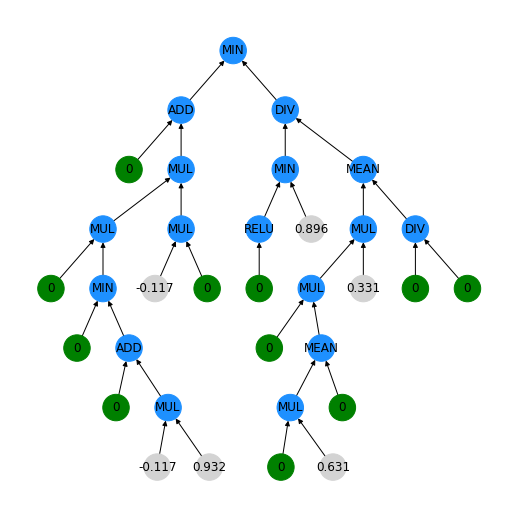

In [19]:
plt.figure(figsize=(7,7))
graph, labels, color_map = get_graph(GP_online.model_.tree)
nx.draw(graph, pos=nx.nx_agraph.graphviz_layout(graph.reverse(), prog="dot"), with_labels=True, labels=labels, node_size=700, node_color=color_map)

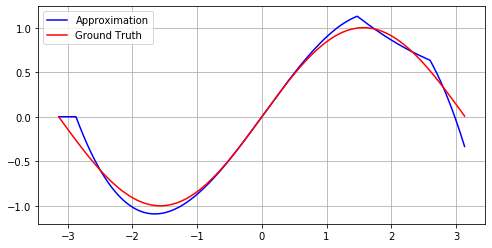

In [20]:
y = GP_online.predict(x)

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.grid(True)

line1, = ax.plot(x, y, 'b-', label='Approximation')
line2, = ax.plot(x, y2, 'r-', label='Ground Truth')

ax.legend()
plt.show()